## ResNet-18

### Imports and constants

In [1]:
import os

os.chdir(os.pardir)
print(os.getcwd())

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection


In [6]:
import pandas as pd
import mlflow
import torch
import torch.nn as nn
import torchvision
import preprocessing.data_collector
import preprocessing.data_processor
import train_eval.train
import train_eval.eval

import importlib

importlib.reload(preprocessing.data_collector)
importlib.reload(preprocessing.data_processor)
importlib.reload(train_eval.train)
importlib.reload(train_eval.eval)

<module 'train_eval.eval' from '/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/train_eval/eval.py'>

In [3]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")

In [4]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [5]:
collector = preprocessing.data_collector.DataCollector()
processor = preprocessing.data_processor.DataProcessor(batch_size=16)

collector.run()
train_loader, val_loader, test_loader = processor.run()

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
Initial number of images: 480
Number of corrupted images: 0


/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.11/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)


Number of duplicates removed: 263
Number of images after removing corrupted and duplicated images: 217
All images have the same size and number of channels.


In [13]:
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
model.fc = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())

for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

optim = torch.optim.Adam(model.parameters())
model.to(device)
print()

In [14]:
def epoch_finished_callback(epoch_number: int, model: nn.Module):
    if epoch_number == 20:
        for name, param in model.named_parameters():
            if "fc" not in name and "layer4" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    if epoch_number == 60:
        for name, param in model.named_parameters():
            if "fc" not in name and "layer4" not in name and "layer3" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

2024/07/19 01:14:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..


100%|██████████| 90/90 [03:11<00:00,  2.13s/it, Train Loss=0.123, Validation Loss=1.18, Validation Accuracy=0.63]    


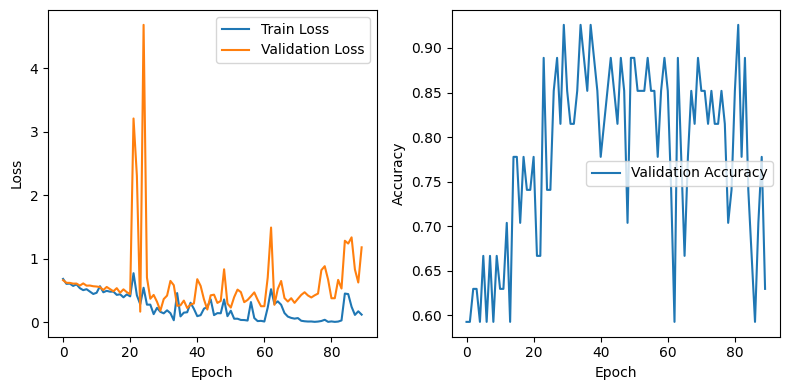

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


           Validation      Test
Accuracy     0.888889  0.857143
Precision    0.875000  0.928571
Recall       0.933333  0.812500
F1-Score     0.903226  0.866667


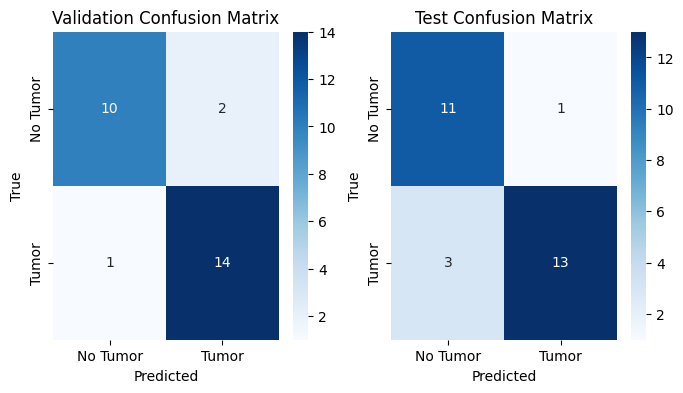

In [15]:
mlflow.set_experiment("Brain Tumor Detection - Model Training and Evaluation")

time_now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")

mlflow.start_run(run_name=f"resnet18-{time_now}", log_system_metrics=True)

run_id = mlflow.active_run().info.run_id

num_epochs = 90

trainer = train_eval.train.ModelTrainer(
    model=model,
    optimizer=optim,
    criterion=nn.BCELoss(),
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    model_name="resnet18",
    mlflow_logging=True,
    train_transform=processor.train_transform,
    test_transform=processor.test_transform,
    plot=True,
    epoch_finished_callback=epoch_finished_callback,
    extra_mlflow_params=[
        ("Training Type", "Fine-Tuning"),
        (
            "Freezing Layers",
            {
                "Epochs 0-20": "All layers frozen except fc",
                "Epochs 21-60": "All layers frozen except fc and layer4",
                "Epochs 61-": "All layers frozen except fc, layer4 and layer3",
            },
        ),
    ],
)
model = trainer.run()

evaluator = train_eval.eval.ModelEvaluator(
    model=model,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.BCELoss(),
    device=device,
    mlflow_logging=True,
    plot=True,
)
evaluator.run()

mlflow.end_run()